In [9]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp

import separate_L63
import separate_solvers as solvers
import separate_utils as utils

reload(separate_L63)
reload(solvers)
reload(utils)

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [10]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, 1, -1])

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0


def plot(c1s, c2s, c3s, u_errors, g1, g2, g3, tls):
    num_iters = len(c1s)
    ils = np.arange(num_iters)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.hlines(g1, ils[0], ils[-1], label="g1", color="black")
    ax.plot(ils, c1s, label="c1")
    ax.legend()
    ax.set_title("c1 vs g1")
    ax.set_xlabel("Iteration number")

    ax = axs[0, 1]
    ax.hlines(g2, ils[0], ils[-1], label="g2", color="black")
    ax.plot(ils, c2s, label="c2")
    ax.legend()
    ax.set_title("c2 vs g2")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 0]
    ax.hlines(g3, ils[0], ils[-1], label="g3", color="black")
    ax.plot(ils, c3s, label="c3")
    ax.legend()
    ax.set_title("c3 vs g3")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 1]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

In [21]:
# System evolution parameters
sigma, rho, beta = g1, g2, g3 = 10, 28, 8 / 3
c1, c2, c3 = g1, g2, g3
c1 *= 1.1
c2 *= 0.9
c3 *= 1.1
μ = 50

gs = jnp.array([g1, g2, g3])
bs = jnp.array([])
cs = jnp.array([c1, c2, c3])

observed_slice = jnp.s_[:]
system = separate_L63.L63(μ, gs, bs, cs, observed_slice)
true_solver = solvers.RK4(system)
nudged_solver = solvers.ForwardEuler(system)
nudged_solver = solvers.TwoStepAdamsBashforth(system, nudged_solver)

# Simulation parameters
dt = 0.001
T0, Tf = 0, 3000
t_relax = 1

cs, u_errors, tls = utils.run_update(
    system,
    true_solver,
    nudged_solver,
    dt,
    T0,
    Tf,
    t_relax,
    *get_initial_values(),
)

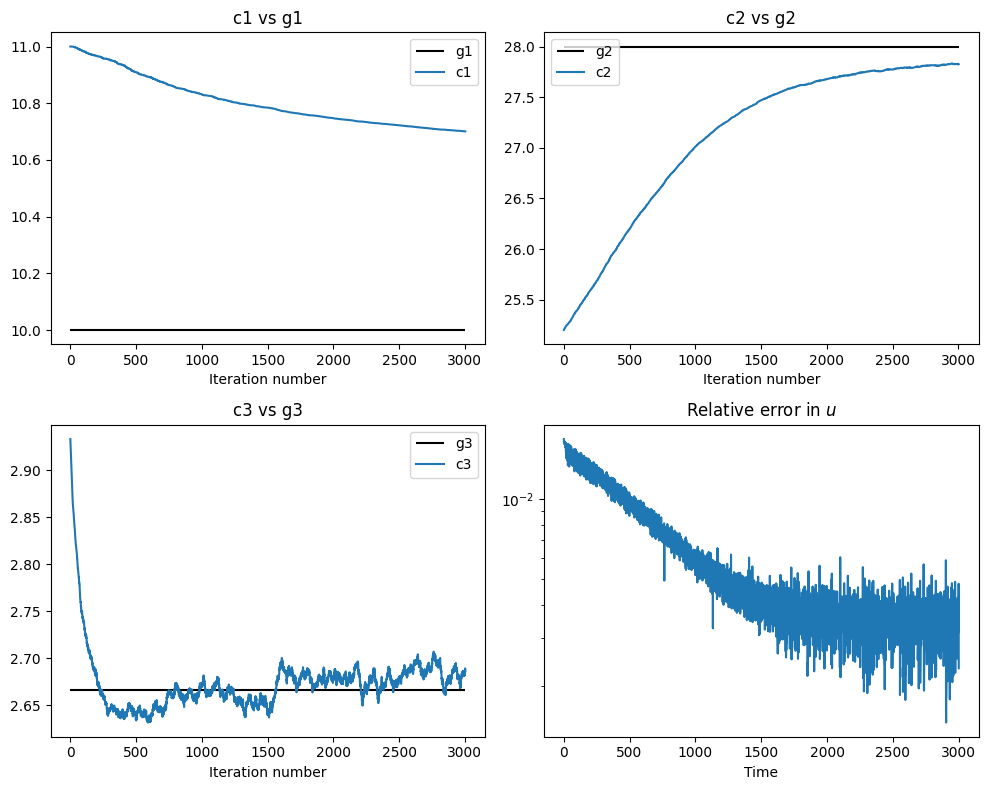

In [22]:
fig, axs = plot(cs.T[0], cs.T[1], cs.T[2], u_errors, g1, g2, g3, tls)
plt.show()